In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

0: 640x576 1 head, 473.3ms
Speed: 5.1ms preprocess, 473.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x640 1 head, 1 body, 342.3ms
Speed: 4.0ms preprocess, 342.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 1 head, 308.7ms
Speed: 4.2ms preprocess, 308.7ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 head, 1 body, 245.6ms
Speed: 7.2ms preprocess, 245.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 head, 221.3ms
Speed: 3.7ms preprocess, 221.3ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 head, 1 body, 203.1ms
Speed: 4.1ms preprocess, 203.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 head, 198.0ms
Speed: 4.7ms preprocess, 198.0ms inference, 5.6ms postprocess p

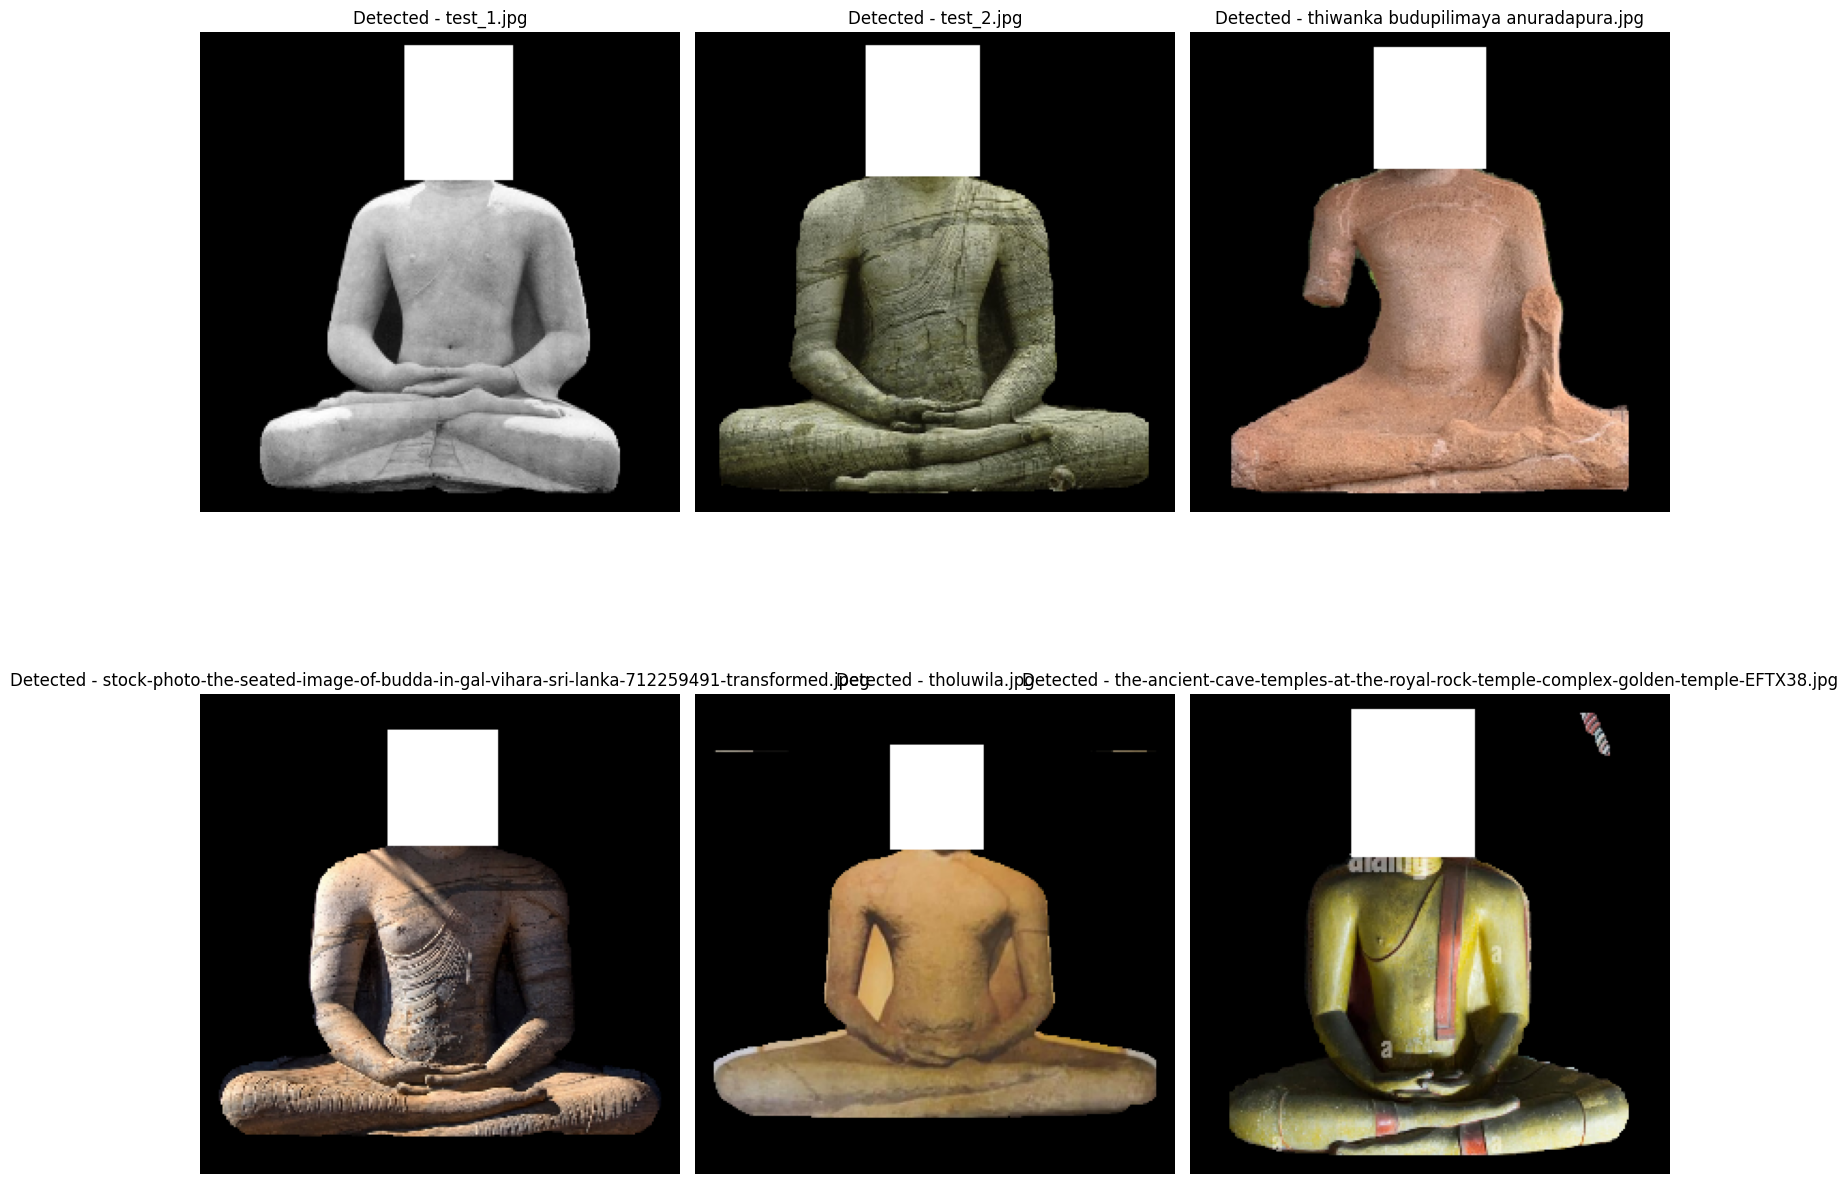

In [12]:
from ultralytics import YOLO
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Path configurations
segmentation_model_path = '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_Detect_Mask/Segment_Model/best.pt'
detection_model_path = '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_Detect_Mask/Detect_Model/best.pt'
image_folder = '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_Detect_Mask/test/'
output_folder = './final_outputs/'

#output image size (Here 256x256, Change it as needed)
image_size = 256
padding = 10

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load models
segmentation_model = YOLO(segmentation_model_path)
detection_model = YOLO(detection_model_path)

def fill_boxes(image, boxes, target_class_id):
    for box in boxes:
        class_id = int(box.cls[0].item())
        if class_id == target_class_id:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 255), thickness=-1)
    return image

def visualize_images_grid(images, titles, grid_size=(3, 3)):
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axs = axs.flatten()
    for img, title, ax in zip(images, titles, axs):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close(fig)

target_class_id = 0
images = []
titles = []

image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
num_images = len(image_files)
grid_cols = 3
grid_rows = (num_images + grid_cols - 1) // grid_cols

for image_name in image_files:
    image_path = os.path.join(image_folder, image_name)
    img = cv2.imread(image_path)
    if img is None:
        continue

    H, W, _ = img.shape
    results = segmentation_model(img)

    for result in results:
        for j, mask in enumerate(result.masks.data):
            mask = mask.cpu().numpy()
            mask_resized = cv2.resize(mask, (W, H))
            mask_resized = (mask_resized > 0.5).astype(np.uint8)
            cropped_img = cv2.bitwise_and(img, img, mask=mask_resized)
            contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            x, y, w, h = cv2.boundingRect(contours[0])
            cropped_img = cropped_img[y:y+h, x:x+w]

            max_dim = image_size - 2 * padding
            if w > max_dim or h > max_dim:
                scale = min(max_dim / w, max_dim / h)
                cropped_img = cv2.resize(cropped_img, (int(w * scale), int(h * scale)))
                w, h = cropped_img.shape[1], cropped_img.shape[0]

            canvas = np.zeros((image_size, image_size, 3), dtype=np.uint8)
            start_x = (image_size - w) // 2
            start_y = (image_size - h) // 2
            canvas[start_y:start_y+h, start_x:start_x+w] = cropped_img

            output_path = os.path.join(output_folder, f'segmented_{os.path.splitext(image_name)[0]}.png')
            #If you need segmented images, execute below line as well
            #cv2.imwrite(output_path, canvas)

            detection_results = detection_model(canvas)
            for detection_result in detection_results:
                filtered_boxes = [box for box in detection_result.boxes if int(box.cls[0].item()) == target_class_id]
                img_with_boxes = fill_boxes(canvas.copy(), filtered_boxes, target_class_id)
                final_output_path = os.path.join(output_folder, image_name)
                cv2.imwrite(final_output_path, img_with_boxes)
                images.append(img_with_boxes)
                titles.append(f'Detected - {image_name}')

visualize_images_grid(images, titles, grid_size=(grid_rows, grid_cols))
